In [1]:
import optuna
import warnings
import gc
import os
import random
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from datetime import datetime
from glob import glob
from tqdm import tqdm
from IPython.display import Image

In [2]:
# 추후에 경고 값들을 출력하지 않도록 'ignore'상태로 만들어 준다.
# 불필요한 경고창이 더 이상 출력 되지 않게 됩니다.
warnings.filterwarnings(action = 'ignore')

### 연도별 데이터를 불러온다.

연도별 데이터는 각기 다른 특징 값들을 갖고 있기 때문에 각기 다른 변수에 할당해 줘야 합니다. 데이터에 대한 자세한 사항은 'KNOW 메타데이터' 폴더를 통해서 확인할 수 있습니다.

In [2]:

train_2017 = []


train_2017 = pd.read_csv('/Users/home/Downloads/KNOW_data/train/KNOW_2017.csv')


test_2017 = []

test_2017 = pd.read_csv('/Users/home/Downloads/KNOW_data/test/KNOW_2017_test.csv')




### 가장 먼저 2017 데이터를 확인해 보도록 하겠습니다.

* 데이터 확인 순서는 2017년부터 2020년 순으로 진행하도록 하겠습니다.

### 1.1 공백으로 구성된 결측치 값을 np.nan으로 변경

데이터에 포함된 모든 결측치 값들은 스페이스를 통해서 나타나고 있습니다. 따라서, 이러한 결측치 값을 확인하기 편하도록 모두 np.nan 값으로 변형해줍니다.

In [3]:
# 데이터의 결측치 값이 ' '기준으로 나타나기 때문에 결측치가 보이지 않는다.
train_2017.isnull().sum()

idx         0
aq1_1       0
aq1_2       0
aq2_1       0
aq2_2       0
           ..
bq40        0
bq41_1      0
bq41_2      0
bq41_3      0
knowcode    0
Length: 156, dtype: int64

In [4]:
# 결측치 값 확인을 편하게 하기 위해서 모두 np.nan 값으로 바꿔준다
# train_2017에 있는 모든 columns들을 불러온다.
for col in train_2017:
        train_2017[col].replace(' ', np.nan, inplace = True)
        if col != 'knowcode':
            test_2017[col].replace(' ', np.nan, inplace = True)

In [5]:
# 정상적으로 결측치 값이 나타나는 것을 확인할 수 있습니다.
train_2017.isnull().sum()

idx            0
aq1_1          0
aq1_2        585
aq2_1          0
aq2_2        861
            ... 
bq40        1301
bq41_1      1332
bq41_2      8222
bq41_3      1316
knowcode       0
Length: 156, dtype: int64

In [6]:
# idx와 knowcode를 제외하고는 154개의 특징들로 구성되어 있는 것을 확인할 수 있다.
train_2017.head(1)

idx  aq1_1 aq1_2  aq2_1 aq2_2  aq3_1 aq3_2  aq4_1 aq4_2  aq5_1  ... bq37  \
0    0      3     3      3     3      3     3      4     4      3  ...   52   

   bq38 bq38_1  bq39_1 bq39_2  bq40 bq41_1  bq41_2 bq41_3  knowcode  
0     2     실업       1      1     1   4000     NaN   2200    825101  

[1 rows x 156 columns]

### 1.2 데이터 타입 분포도 확인

In [7]:
# 데이터의 타입 분포도는 int형이 93개, object형이 60개, float 64형이 1개 있는 것을
# 확인할 수 있다.

test_2017[test_2017.columns[1:]].dtypes.value_counts()

int64      93
object     60
float64     1
dtype: int64

* 데이터 타입에서 유일하게 존재하는 float 타입의 컬럼 값이다.
* KNOW 메타데이터에 폴더에 있는 변수 정보 pdf를 통해서 이 특징 값을 확인해 보자.
* '기술적 변화 요인으로 인한 업무 대체 비율' 라고 명시되어 있다.
* 비율 값이기 때문에 float형인 것은 타당해 보인다.

In [8]:
test_2017.select_dtypes('float64')

bq23
0      0.0
1     30.0
2     10.0
3      2.0
4     15.0
...    ...
9481   0.0
9482  70.0
9483   0.0
9484  50.0
9485  20.0

[9486 rows x 1 columns]

### 1.3 학습 데이터와 테스트 데이터에서 결측치 값이 포함된 칼럼과 개수 확인

결측치 값이 포함된 칼럼을 아래와 같이 손쉽게 확인할 수 있다.<br>
왼쪽은 학습 데이터에 대한 결측치 값, 중간은 테스트에 대한 결측치 값, 마지막은 학습 데이터와 테스트 데이터에 있는 결측치 수의 합이다.

In [9]:
for index, value, tindex, tvalue in zip(train_2017.isnull().sum().index, train_2017.isnull().sum(), test_2017.isnull().sum().index, test_2017.isnull().sum()):
    print(f"{index} : {value} / {tindex} : {tvalue} / {value + tvalue}")

idx : 0 / idx : 0 / 0
aq1_1 : 0 / aq1_1 : 0 / 0
aq1_2 : 585 / aq1_2 : 598 / 1183
aq2_1 : 0 / aq2_1 : 0 / 0
aq2_2 : 861 / aq2_2 : 862 / 1723
aq3_1 : 0 / aq3_1 : 0 / 0
aq3_2 : 843 / aq3_2 : 785 / 1628
aq4_1 : 0 / aq4_1 : 0 / 0
aq4_2 : 3118 / aq4_2 : 3099 / 6217
aq5_1 : 0 / aq5_1 : 0 / 0
aq5_2 : 2282 / aq5_2 : 2170 / 4452
aq6_1 : 0 / aq6_1 : 0 / 0
aq6_2 : 1676 / aq6_2 : 1612 / 3288
aq7_1 : 0 / aq7_1 : 0 / 0
aq7_2 : 1537 / aq7_2 : 1470 / 3007
aq8_1 : 0 / aq8_1 : 0 / 0
aq8_2 : 1606 / aq8_2 : 1546 / 3152
aq9_1 : 0 / aq9_1 : 0 / 0
aq9_2 : 1396 / aq9_2 : 1352 / 2748
aq10_1 : 0 / aq10_1 : 0 / 0
aq10_2 : 942 / aq10_2 : 908 / 1850
aq11_1 : 0 / aq11_1 : 0 / 0
aq11_2 : 2745 / aq11_2 : 2742 / 5487
aq12_1 : 0 / aq12_1 : 0 / 0
aq12_2 : 1064 / aq12_2 : 1076 / 2140
aq13_1 : 0 / aq13_1 : 0 / 0
aq13_2 : 1445 / aq13_2 : 1436 / 2881
aq14_1 : 0 / aq14_1 : 0 / 0
aq14_2 : 1550 / aq14_2 : 1535 / 3085
aq15_1 : 0 / aq15_1 : 0 / 0
aq15_2 : 764 / aq15_2 : 771 / 1535
aq16_1 : 0 / aq16_1 : 0 / 0
aq16_2 : 1871 / aq16_

### 1.4 데이터 결측치 값이 포함된 결측치 값 처리

결측치 값이 포함된 칼럼에 대한 특징을 확인해보고 이에 대한 결측치 처리를 실시해 보겠다. <br>
우선적으로 'aq1_2' 칼럼 값에 해당하는 결측치 값을 보도록 하자. 

아래의 설문지를 확인해 보자.<br>
밑의 1번의 가번 문항이 'aq1_1'의 칼럼 값에 해당하는 질문이다.<br>
우리가 확인하고자 하는 문항은 나번 문항이다. 나번 문항이 'aq1_2'칼럼에 해당하는 질문이다.<br>

아래의 질문을 통해서 확인할 수 있는 것이 가번 문항에 1번을 체크한 사람은 나번 문항에 응답할 필요가 없다. <br>

<hr>

aq1_2의 결측치 값이 585개 이다. 이때, 가번 문항에 1번을 체크한 사람을 확인해 보자.

#### 가번 문항에 1번을 체크한 사람의 수와 결측치 값의 수가 동일한 것을 확인 할 수 있다. 따라서, 이러한 결측치 값은 정상적인 값이다.

In [11]:
# 가번 문항에서 1번을 체크한 사람의 수
train_2017[(train_2017['aq1_2'].isnull()) &  (train_2017['aq1_1'] == 1)].shape

(585, 156)

<hr>
<hr>
위와 같은 형태의 결측치 값은 다른 항목의 질문에도 동일하게 적용된다.<br>

                 "가번 문항에서 1번을 선택 >> 나번 문항을 건너뜀"
따라서, 이러한 값들에 대해서 동일한 방식으로 처리해 준다.

In [13]:
Image("Image/aq2~3.png")

### 1.5  가번 문항에 1번을 선택한 특징 값 처리
* aq1_1 ~ aq41_2 까지의 모든 칼럼에 동일하게 적용한다.

In [12]:
# 중요하지 않다라고 한 사람들에 대한 
# 결측치 값을 0으로 바꿔준다.
# aq1_1 에서부터 aq41_2 까지의 칼럼들을 뽑아 낸다.
columns = train_2017.columns[1:-1][:82]

# 앞의 결측치 값을 제거하면 뒤의 결측치 값은 제거하면 되기 때문에
# 데이터의 인덱스를 2씩 키운다.
for index in range(0,82,2):
    col = columns[index]
    
    # before가 가번 문항에 해당한다. 
    # after는 나번 문항에 해당한다. 
    before = col
    after = col[:-1] + str((int(col[-1])+1))
    print(before, after)
    
    # 일단 before 자체도 결측치 값이면 안된다.
    # 그리고 after 값이 결측치 값인 것을 확인한다.
    # after 값이 결측치 값이라는 것은 가번 문항에서 1번 을 선택한 것이기 때문에 0으로 할당해 줘야 한다.
    train_2017.loc[(train_2017[after].isnull()) & (train_2017[before].notnull()) & (train_2017[before] == (sorted(train_2017[before].unique()))[0]), after] = 0
    test_2017.loc[(test_2017[after].isnull()) & (test_2017[before].notnull()) & (test_2017[before] == (sorted(test_2017[before].unique()))[0]), after] = 0

aq1_1 aq1_2
aq2_1 aq2_2
aq3_1 aq3_2
aq4_1 aq4_2
aq5_1 aq5_2
aq6_1 aq6_2
aq7_1 aq7_2
aq8_1 aq8_2
aq9_1 aq9_2
aq10_1 aq10_2
aq11_1 aq11_2
aq12_1 aq12_2
aq13_1 aq13_2
aq14_1 aq14_2
aq15_1 aq15_2
aq16_1 aq16_2
aq17_1 aq17_2
aq18_1 aq18_2
aq19_1 aq19_2
aq20_1 aq20_2
aq21_1 aq21_2
aq22_1 aq22_2
aq23_1 aq23_2
aq24_1 aq24_2
aq25_1 aq25_2
aq26_1 aq26_2
aq27_1 aq27_2
aq28_1 aq28_2
aq29_1 aq29_2
aq30_1 aq30_2
aq31_1 aq31_2
aq32_1 aq32_2
aq33_1 aq33_2
aq34_1 aq34_2
aq35_1 aq35_2
aq36_1 aq36_2
aq37_1 aq37_2
aq38_1 aq38_2
aq39_1 aq39_2
aq40_1 aq40_2
aq41_1 aq41_2


* 가번 문항에 1번을 선택하고 나번 문항에 결측치 값이 모든 값들을 0으로 채웠다.
* 그럼에도 일부 결측치 값이 남아 있는 것을 확인할 수 있다.
* 이러한 결측치 값을 처리하도록 하자.

In [13]:
train_nan_columns = []
test_nan_columns = []
for index, value, tindex, tvalue in zip(train_2017.isnull().sum().index, train_2017.isnull().sum(), test_2017.isnull().sum().index, test_2017.isnull().sum()):
    print(f"{index} : {value} / {tindex} : {tvalue} / {value + tvalue}")
    if value != 0 :
        train_nan_columns.append(index)
    if tvalue != 0:
        test_nan_columns.append(tindex)

idx : 0 / idx : 0 / 0
aq1_1 : 0 / aq1_1 : 0 / 0
aq1_2 : 0 / aq1_2 : 0 / 0
aq2_1 : 0 / aq2_1 : 0 / 0
aq2_2 : 0 / aq2_2 : 0 / 0
aq3_1 : 0 / aq3_1 : 0 / 0
aq3_2 : 0 / aq3_2 : 0 / 0
aq4_1 : 0 / aq4_1 : 0 / 0
aq4_2 : 0 / aq4_2 : 0 / 0
aq5_1 : 0 / aq5_1 : 0 / 0
aq5_2 : 0 / aq5_2 : 0 / 0
aq6_1 : 0 / aq6_1 : 0 / 0
aq6_2 : 0 / aq6_2 : 0 / 0
aq7_1 : 0 / aq7_1 : 0 / 0
aq7_2 : 0 / aq7_2 : 0 / 0
aq8_1 : 0 / aq8_1 : 0 / 0
aq8_2 : 0 / aq8_2 : 0 / 0
aq9_1 : 0 / aq9_1 : 0 / 0
aq9_2 : 0 / aq9_2 : 0 / 0
aq10_1 : 0 / aq10_1 : 0 / 0
aq10_2 : 0 / aq10_2 : 0 / 0
aq11_1 : 0 / aq11_1 : 0 / 0
aq11_2 : 4 / aq11_2 : 6 / 10
aq12_1 : 0 / aq12_1 : 0 / 0
aq12_2 : 0 / aq12_2 : 0 / 0
aq13_1 : 0 / aq13_1 : 0 / 0
aq13_2 : 0 / aq13_2 : 0 / 0
aq14_1 : 0 / aq14_1 : 0 / 0
aq14_2 : 3 / aq14_2 : 9 / 12
aq15_1 : 0 / aq15_1 : 0 / 0
aq15_2 : 0 / aq15_2 : 0 / 0
aq16_1 : 0 / aq16_1 : 0 / 0
aq16_2 : 0 / aq16_2 : 0 / 0
aq17_1 : 0 / aq17_1 : 0 / 0
aq17_2 : 0 / aq17_2 : 0 / 0
aq18_1 : 0 / aq18_1 : 0 / 0
aq18_2 : 0 / aq18_2 : 0 / 0
aq19

* aq에 해당하는 칼럼들에 대한 결측치 값을 처리해 보자.
* 'aq11_2' 에서 부터 'aq41_2' 순으로 결측치 처리를 해보자.

In [14]:
train_nan_columns

['aq11_2',
 'aq14_2',
 'aq27_2',
 'aq32_2',
 'aq41_2',
 'bq4_1a',
 'bq4_1b',
 'bq4_1c',
 'bq5_1',
 'bq5_2',
 'bq12_2',
 'bq12_3',
 'bq12_4',
 'bq19_1',
 'bq31',
 'bq32',
 'bq33',
 'bq34',
 'bq38_1',
 'bq40',
 'bq41_1',
 'bq41_2',
 'bq41_3']

### 1.6  aq11_2에 해당하는 결측치 처리 방법

흥미로운 점은 학습 데이터와 테스트 데이터 모두에서 가번 문항을 3으로 선택했다는 것이다. <br>
가번 문항을 선택한 사람들이 나번 문항에서 어떠한 선택을 했는지 확인해 보자.

In [15]:
train_2017[(train_2017['aq11_2'].isnull())]['aq11_1']

89      3
577     3
2422    3
4568    3
Name: aq11_1, dtype: int64

In [16]:
test_2017[(test_2017['aq11_2'].isnull())]['aq11_1']

4319    3
5290    3
5960    3
6775    3
6877    3
7350    3
Name: aq11_1, dtype: int64

가번 문항에서 3번을 선택하고 나번 문항에서 결측치가 포함되지 않은 사람들을 뽑는다.

In [17]:
total_2017 = pd.concat([train_2017[(train_2017['aq11_2'].notnull()) & (train_2017['aq11_1'] == 3)], test_2017[(test_2017['aq11_2'].notnull()) & (test_2017['aq11_1'] == 3)]], axis = 0)

가번 문항에서 3번을 선택한 대부분의 사람들이 나번 문항에서 4번을 많이 선택한 것을 볼 수 있다.

count    4442.000000
mean        3.845115
std         0.838641
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         7.000000
Name: aq11_2, dtype: float64


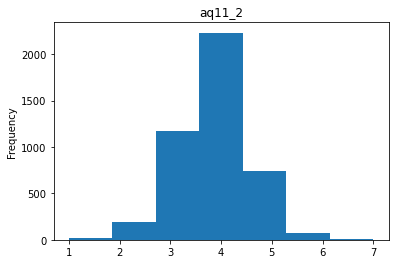

In [18]:
print(total_2017['aq11_2'].astype('int').describe())

total_2017['aq11_2'].astype('int').plot.hist(bins = 7, title = "aq11_2")

* 결측치 값들을 중앙 값으로 대체 해준다.
    * 좀 더 세밀한 조정을 하고 싶다면 다른 컬럼 값들과 비교한 후에 결측치를 변경하는 것이 더욱 바람직하다.
    * 하지만 지금은 BaseLine 코드를 작성하는 것이기 때문에 중앙 값으로 일시적으로 대체한 후에 점수를 측정해볼 것이다.

In [19]:
# 중앙 값으로 결측치 값을 처리해 준다.
# 'train_2017.loc[train_2017['aq11_2'].isnull()] = 4'와 동일한 구문이다.
train_2017.loc[train_2017['aq11_2'].isnull()] = total_2017['aq11_2'].astype('int').quantile(q = 0.5)

# 'test_2017.loc[test_2017['aq11_2'].isnull()] = 4'와 동일한 구문이다.
test_2017.loc[test_2017['aq11_2'].isnull()] = total_2017['aq11_2'].astype('int').quantile(q = 0.5)

* 결측치가 정상적으로 제거된 모습을 볼 수 있다.

In [20]:
print(sum(train_2017['aq11_2'].isnull()))
print(sum(test_2017['aq11_2'].isnull()))

0
0


### 1.7  aq14_2에 해당하는 결측치 처리 방법

* 가번 질문 "귀하의 업무를 하기 위해【업무, 활동에 대한 일정관리】활동이 얼마나 중요합니까?"
* 나번 질문 "귀하의 업무에 필요한【업무, 활동에 대한 일정관리】활동의 수준은 어느 정도라고 생각하십니까?"

이번 결측치 값에서는 가번 문항에서 3번과 4번을 선택한 사람이 섞여 있는 것을 확인할 수 있다. 따라서, 3번을 선택한 사람과 4번을 선택한 사람을 나눠서 결측치를 처리해야 한다.

In [21]:
train_2017[(train_2017['aq14_2'].isnull())]['aq14_1']

3137    4.0
4564    4.0
6539    3.0
Name: aq14_1, dtype: float64

In [22]:
test_2017[(test_2017['aq14_2'].isnull())]['aq14_1']

723     3.0
1234    3.0
1452    3.0
2026    3.0
3083    3.0
5078    4.0
6270    3.0
7139    3.0
7320    3.0
Name: aq14_1, dtype: float64

* 우선적으로 가번 문항에서 3번을 선택한 사람들의 결측치 값을 처리해 보자.

In [23]:
# 가번 문항에서 3번을 선택한 사람의 중앙 값을 알기 위해서 전체 데이터로 합친다.
total_2017 = pd.concat([train_2017[(train_2017['aq14_2'].notnull()) & (train_2017['aq14_1'] == 3)], test_2017[(test_2017['aq14_2'].notnull()) & (test_2017['aq14_1'] == 3)]], axis = 0)
total_2017.shape

(6333, 156)

In [24]:
print(total_2017['aq14_2'].astype('int').describe())

total_2017['aq14_2'].astype('int').plot.hist(bins = 7, title = "aq14_2")

count    6333.000000
mean        3.822201
std         0.810524
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         7.000000
Name: aq14_2, dtype: float64


In [25]:
# 가번 문항에서 3번을 선택한 사람들을 나번 문항의 중앙 값을 통해서 처리해준다.

train_2017.loc[(train_2017['aq14_2'].isnull()) & (train_2017['aq14_1'] == 3)] = total_2017['aq14_2'].astype('int').quantile(q = 0.5)
test_2017.loc[(test_2017['aq14_2'].isnull()) & (test_2017['aq14_1'] == 3)] = total_2017['aq14_2'].astype('int').quantile(q = 0.5)

In [28]:
display(train_2017.loc[(train_2017['aq14_2'].isnull()) & (train_2017['aq14_1'] == 3)])
display(test_2017.loc[(test_2017['aq14_2'].isnull()) & (test_2017['aq14_1'] == 3)])

Empty DataFrame
Columns: [idx, aq1_1, aq1_2, aq2_1, aq2_2, aq3_1, aq3_2, aq4_1, aq4_2, aq5_1, aq5_2, aq6_1, aq6_2, aq7_1, aq7_2, aq8_1, aq8_2, aq9_1, aq9_2, aq10_1, aq10_2, aq11_1, aq11_2, aq12_1, aq12_2, aq13_1, aq13_2, aq14_1, aq14_2, aq15_1, aq15_2, aq16_1, aq16_2, aq17_1, aq17_2, aq18_1, aq18_2, aq19_1, aq19_2, aq20_1, aq20_2, aq21_1, aq21_2, aq22_1, aq22_2, aq23_1, aq23_2, aq24_1, aq24_2, aq25_1, aq25_2, aq26_1, aq26_2, aq27_1, aq27_2, aq28_1, aq28_2, aq29_1, aq29_2, aq30_1, aq30_2, aq31_1, aq31_2, aq32_1, aq32_2, aq33_1, aq33_2, aq34_1, aq34_2, aq35_1, aq35_2, aq36_1, aq36_2, aq37_1, aq37_2, aq38_1, aq38_2, aq39_1, aq39_2, aq40_1, aq40_2, aq41_1, aq41_2, bq1, bq2, bq3, bq4, bq4_1a, bq4_1b, bq4_1c, bq5, bq5_1, bq5_2, bq6, bq7, bq8_1, bq8_2, bq8_3, bq9, bq10, ...]
Index: []

[0 rows x 156 columns]

Empty DataFrame
Columns: [idx, aq1_1, aq1_2, aq2_1, aq2_2, aq3_1, aq3_2, aq4_1, aq4_2, aq5_1, aq5_2, aq6_1, aq6_2, aq7_1, aq7_2, aq8_1, aq8_2, aq9_1, aq9_2, aq10_1, aq10_2, aq11_1, aq11_2, aq12_1, aq12_2, aq13_1, aq13_2, aq14_1, aq14_2, aq15_1, aq15_2, aq16_1, aq16_2, aq17_1, aq17_2, aq18_1, aq18_2, aq19_1, aq19_2, aq20_1, aq20_2, aq21_1, aq21_2, aq22_1, aq22_2, aq23_1, aq23_2, aq24_1, aq24_2, aq25_1, aq25_2, aq26_1, aq26_2, aq27_1, aq27_2, aq28_1, aq28_2, aq29_1, aq29_2, aq30_1, aq30_2, aq31_1, aq31_2, aq32_1, aq32_2, aq33_1, aq33_2, aq34_1, aq34_2, aq35_1, aq35_2, aq36_1, aq36_2, aq37_1, aq37_2, aq38_1, aq38_2, aq39_1, aq39_2, aq40_1, aq40_2, aq41_1, aq41_2, bq1, bq2, bq3, bq4, bq4_1a, bq4_1b, bq4_1c, bq5, bq5_1, bq5_2, bq6, bq7, bq8_1, bq8_2, bq8_3, bq9, bq10, ...]
Index: []

[0 rows x 155 columns]

<br><br><br>
* 다음으로 4번 문항을 선택한 사람들의 결측치 값을 제거해 보자.

In [29]:
# 가번 문항에서 4번을 선택한 사람의 중앙 값을 알기 위해서 전체 데이터로 합친다.
total_2017 = pd.concat([train_2017[(train_2017['aq14_2'].notnull()) & (train_2017['aq14_1'] == 4)], test_2017[(test_2017['aq14_2'].notnull()) & (test_2017['aq14_1'] == 4)]], axis = 0)
total_2017.shape

(4732, 156)

count    4732.000000
mean        5.013525
std         0.861484
min         1.000000
25%         5.000000
50%         5.000000
75%         6.000000
max         7.000000
Name: aq14_2, dtype: float64


<AxesSubplot:title={'center':'aq14_2'}, ylabel='Frequency'>

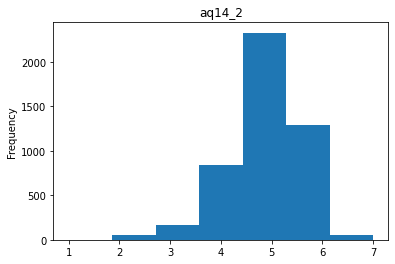

In [30]:
print(total_2017['aq14_2'].astype('int').describe())

total_2017['aq14_2'].astype('int').plot.hist(bins = 7, title = "aq14_2")

In [31]:
# 가번 문항에서 4번을 선택한 사람들을 나번 문항의 중앙 값을 통해서 처리해준다.

train_2017.loc[(train_2017['aq14_2'].isnull()) & (train_2017['aq14_1'] == 4)] = total_2017['aq14_2'].astype('int').quantile(q = 0.5)
test_2017.loc[(test_2017['aq14_2'].isnull()) & (test_2017['aq14_1'] == 4)] = total_2017['aq14_2'].astype('int').quantile(q = 0.5)

In [32]:
display(train_2017.loc[(train_2017['aq14_2'].isnull()) & (train_2017['aq14_1'] == 4)])
display(test_2017.loc[(test_2017['aq14_2'].isnull()) & (test_2017['aq14_1'] == 4)])

Empty DataFrame
Columns: [idx, aq1_1, aq1_2, aq2_1, aq2_2, aq3_1, aq3_2, aq4_1, aq4_2, aq5_1, aq5_2, aq6_1, aq6_2, aq7_1, aq7_2, aq8_1, aq8_2, aq9_1, aq9_2, aq10_1, aq10_2, aq11_1, aq11_2, aq12_1, aq12_2, aq13_1, aq13_2, aq14_1, aq14_2, aq15_1, aq15_2, aq16_1, aq16_2, aq17_1, aq17_2, aq18_1, aq18_2, aq19_1, aq19_2, aq20_1, aq20_2, aq21_1, aq21_2, aq22_1, aq22_2, aq23_1, aq23_2, aq24_1, aq24_2, aq25_1, aq25_2, aq26_1, aq26_2, aq27_1, aq27_2, aq28_1, aq28_2, aq29_1, aq29_2, aq30_1, aq30_2, aq31_1, aq31_2, aq32_1, aq32_2, aq33_1, aq33_2, aq34_1, aq34_2, aq35_1, aq35_2, aq36_1, aq36_2, aq37_1, aq37_2, aq38_1, aq38_2, aq39_1, aq39_2, aq40_1, aq40_2, aq41_1, aq41_2, bq1, bq2, bq3, bq4, bq4_1a, bq4_1b, bq4_1c, bq5, bq5_1, bq5_2, bq6, bq7, bq8_1, bq8_2, bq8_3, bq9, bq10, ...]
Index: []

[0 rows x 156 columns]

Empty DataFrame
Columns: [idx, aq1_1, aq1_2, aq2_1, aq2_2, aq3_1, aq3_2, aq4_1, aq4_2, aq5_1, aq5_2, aq6_1, aq6_2, aq7_1, aq7_2, aq8_1, aq8_2, aq9_1, aq9_2, aq10_1, aq10_2, aq11_1, aq11_2, aq12_1, aq12_2, aq13_1, aq13_2, aq14_1, aq14_2, aq15_1, aq15_2, aq16_1, aq16_2, aq17_1, aq17_2, aq18_1, aq18_2, aq19_1, aq19_2, aq20_1, aq20_2, aq21_1, aq21_2, aq22_1, aq22_2, aq23_1, aq23_2, aq24_1, aq24_2, aq25_1, aq25_2, aq26_1, aq26_2, aq27_1, aq27_2, aq28_1, aq28_2, aq29_1, aq29_2, aq30_1, aq30_2, aq31_1, aq31_2, aq32_1, aq32_2, aq33_1, aq33_2, aq34_1, aq34_2, aq35_1, aq35_2, aq36_1, aq36_2, aq37_1, aq37_2, aq38_1, aq38_2, aq39_1, aq39_2, aq40_1, aq40_2, aq41_1, aq41_2, bq1, bq2, bq3, bq4, bq4_1a, bq4_1b, bq4_1c, bq5, bq5_1, bq5_2, bq6, bq7, bq8_1, bq8_2, bq8_3, bq9, bq10, ...]
Index: []

[0 rows x 155 columns]

### 1.8  aq27_2에 해당하는 결측치 처리 방법
* 결측치 처리 방식은 위와 동일하다.
* 다시 한번 강조하지만 BaseLine 코드를 작성하는 것이기 때문에 세밀한 결측치 처리를 하지 않고 있다. 추후에 점수를 올리기 위해서는 다른 특징 값과 연결 시켜서 결측치를 처리해야 한다.
* 아래의 'aq27_2' 칼럼 값 또한 가번 문항에서 3번과 4번을 선택했다.

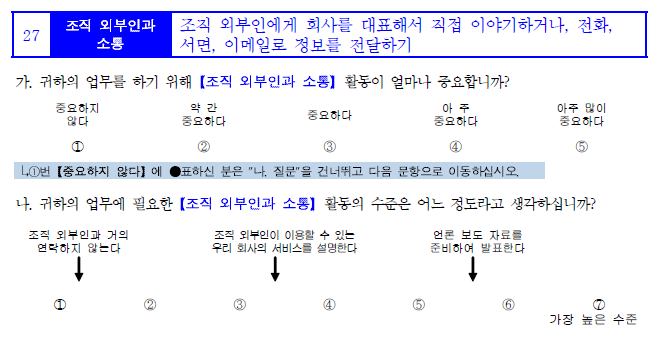

In [33]:
Image("Image/aq27_2.png")

In [34]:
train_2017[(train_2017['aq27_2'].isnull())]['aq27_1']

715     3
792     3
3960    3
4060    3
5388    3
6383    4
9449    3
Name: aq27_1, dtype: int64

In [35]:
test_2017[(test_2017['aq27_2'].isnull())]['aq27_1']

2302    3
2479    3
2667    3
3334    4
6279    3
8052    3
Name: aq27_1, dtype: int64

#### 결측치 처리 방식은 위와 동일하기 때문에 별도의 설명은 생략 하도록 하겠다.

In [36]:
# 가번 문항에서 3번을 선택한 사람을 우선적으로 처리한다.

total_2017 = pd.concat([train_2017[(train_2017['aq27_2'].notnull()) & (train_2017['aq27_1'] == 3)], test_2017[(test_2017['aq27_2'].notnull()) & (test_2017['aq27_1'] == 3)]], axis = 0)

print(total_2017['aq27_2'].astype('int').describe())

total_2017['aq27_2'].astype('int').plot.hist(bins = 7, title = "aq27_2")

train_2017.loc[(train_2017['aq27_2'].isnull()) & (train_2017['aq27_1'] == 3)] = total_2017['aq27_2'].astype('int').quantile(q = 0.5)
test_2017.loc[(test_2017['aq27_2'].isnull()) & (test_2017['aq27_1'] == 3)] = total_2017['aq27_2'].astype('int').quantile(q = 0.5)

display(train_2017.loc[(train_2017['aq27_2'].isnull()) & (train_2017['aq27_1'] == 3)])
display(test_2017.loc[(test_2017['aq27_2'].isnull()) & (test_2017['aq27_1'] == 3)])

count    6066.000000
mean        3.742994
std         0.743460
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         7.000000
Name: aq27_2, dtype: float64


Empty DataFrame
Columns: [idx, aq1_1, aq1_2, aq2_1, aq2_2, aq3_1, aq3_2, aq4_1, aq4_2, aq5_1, aq5_2, aq6_1, aq6_2, aq7_1, aq7_2, aq8_1, aq8_2, aq9_1, aq9_2, aq10_1, aq10_2, aq11_1, aq11_2, aq12_1, aq12_2, aq13_1, aq13_2, aq14_1, aq14_2, aq15_1, aq15_2, aq16_1, aq16_2, aq17_1, aq17_2, aq18_1, aq18_2, aq19_1, aq19_2, aq20_1, aq20_2, aq21_1, aq21_2, aq22_1, aq22_2, aq23_1, aq23_2, aq24_1, aq24_2, aq25_1, aq25_2, aq26_1, aq26_2, aq27_1, aq27_2, aq28_1, aq28_2, aq29_1, aq29_2, aq30_1, aq30_2, aq31_1, aq31_2, aq32_1, aq32_2, aq33_1, aq33_2, aq34_1, aq34_2, aq35_1, aq35_2, aq36_1, aq36_2, aq37_1, aq37_2, aq38_1, aq38_2, aq39_1, aq39_2, aq40_1, aq40_2, aq41_1, aq41_2, bq1, bq2, bq3, bq4, bq4_1a, bq4_1b, bq4_1c, bq5, bq5_1, bq5_2, bq6, bq7, bq8_1, bq8_2, bq8_3, bq9, bq10, ...]
Index: []

[0 rows x 156 columns]

Empty DataFrame
Columns: [idx, aq1_1, aq1_2, aq2_1, aq2_2, aq3_1, aq3_2, aq4_1, aq4_2, aq5_1, aq5_2, aq6_1, aq6_2, aq7_1, aq7_2, aq8_1, aq8_2, aq9_1, aq9_2, aq10_1, aq10_2, aq11_1, aq11_2, aq12_1, aq12_2, aq13_1, aq13_2, aq14_1, aq14_2, aq15_1, aq15_2, aq16_1, aq16_2, aq17_1, aq17_2, aq18_1, aq18_2, aq19_1, aq19_2, aq20_1, aq20_2, aq21_1, aq21_2, aq22_1, aq22_2, aq23_1, aq23_2, aq24_1, aq24_2, aq25_1, aq25_2, aq26_1, aq26_2, aq27_1, aq27_2, aq28_1, aq28_2, aq29_1, aq29_2, aq30_1, aq30_2, aq31_1, aq31_2, aq32_1, aq32_2, aq33_1, aq33_2, aq34_1, aq34_2, aq35_1, aq35_2, aq36_1, aq36_2, aq37_1, aq37_2, aq38_1, aq38_2, aq39_1, aq39_2, aq40_1, aq40_2, aq41_1, aq41_2, bq1, bq2, bq3, bq4, bq4_1a, bq4_1b, bq4_1c, bq5, bq5_1, bq5_2, bq6, bq7, bq8_1, bq8_2, bq8_3, bq9, bq10, ...]
Index: []

[0 rows x 155 columns]

In [37]:
# 가번 문항에서 4번을 선택한 사람을 처리한다.

total_2017 = pd.concat([train_2017[(train_2017['aq27_2'].notnull()) & (train_2017['aq27_1'] == 4)], test_2017[(test_2017['aq27_2'].notnull()) & (test_2017['aq27_1'] == 4)]], axis = 0)

print(total_2017['aq27_2'].astype('int').describe())

total_2017['aq27_2'].astype('int').plot.hist(bins = 7, title = "aq27_2")

train_2017.loc[(train_2017['aq27_2'].isnull()) & (train_2017['aq27_1'] == 4)] = total_2017['aq27_2'].astype('int').quantile(q = 0.5)
test_2017.loc[(test_2017['aq27_2'].isnull()) & (test_2017['aq27_1'] == 4)] = total_2017['aq27_2'].astype('int').quantile(q = 0.5)

display(train_2017.loc[(train_2017['aq27_2'].isnull()) & (train_2017['aq27_1'] == 4)])
display(test_2017.loc[(test_2017['aq27_2'].isnull()) & (test_2017['aq27_1'] == 4)])

count    4306.000000
mean        4.836507
std         0.856335
min         1.000000
25%         4.000000
50%         5.000000
75%         5.000000
max         7.000000
Name: aq27_2, dtype: float64


Empty DataFrame
Columns: [idx, aq1_1, aq1_2, aq2_1, aq2_2, aq3_1, aq3_2, aq4_1, aq4_2, aq5_1, aq5_2, aq6_1, aq6_2, aq7_1, aq7_2, aq8_1, aq8_2, aq9_1, aq9_2, aq10_1, aq10_2, aq11_1, aq11_2, aq12_1, aq12_2, aq13_1, aq13_2, aq14_1, aq14_2, aq15_1, aq15_2, aq16_1, aq16_2, aq17_1, aq17_2, aq18_1, aq18_2, aq19_1, aq19_2, aq20_1, aq20_2, aq21_1, aq21_2, aq22_1, aq22_2, aq23_1, aq23_2, aq24_1, aq24_2, aq25_1, aq25_2, aq26_1, aq26_2, aq27_1, aq27_2, aq28_1, aq28_2, aq29_1, aq29_2, aq30_1, aq30_2, aq31_1, aq31_2, aq32_1, aq32_2, aq33_1, aq33_2, aq34_1, aq34_2, aq35_1, aq35_2, aq36_1, aq36_2, aq37_1, aq37_2, aq38_1, aq38_2, aq39_1, aq39_2, aq40_1, aq40_2, aq41_1, aq41_2, bq1, bq2, bq3, bq4, bq4_1a, bq4_1b, bq4_1c, bq5, bq5_1, bq5_2, bq6, bq7, bq8_1, bq8_2, bq8_3, bq9, bq10, ...]
Index: []

[0 rows x 156 columns]

Empty DataFrame
Columns: [idx, aq1_1, aq1_2, aq2_1, aq2_2, aq3_1, aq3_2, aq4_1, aq4_2, aq5_1, aq5_2, aq6_1, aq6_2, aq7_1, aq7_2, aq8_1, aq8_2, aq9_1, aq9_2, aq10_1, aq10_2, aq11_1, aq11_2, aq12_1, aq12_2, aq13_1, aq13_2, aq14_1, aq14_2, aq15_1, aq15_2, aq16_1, aq16_2, aq17_1, aq17_2, aq18_1, aq18_2, aq19_1, aq19_2, aq20_1, aq20_2, aq21_1, aq21_2, aq22_1, aq22_2, aq23_1, aq23_2, aq24_1, aq24_2, aq25_1, aq25_2, aq26_1, aq26_2, aq27_1, aq27_2, aq28_1, aq28_2, aq29_1, aq29_2, aq30_1, aq30_2, aq31_1, aq31_2, aq32_1, aq32_2, aq33_1, aq33_2, aq34_1, aq34_2, aq35_1, aq35_2, aq36_1, aq36_2, aq37_1, aq37_2, aq38_1, aq38_2, aq39_1, aq39_2, aq40_1, aq40_2, aq41_1, aq41_2, bq1, bq2, bq3, bq4, bq4_1a, bq4_1b, bq4_1c, bq5, bq5_1, bq5_2, bq6, bq7, bq8_1, bq8_2, bq8_3, bq9, bq10, ...]
Index: []

[0 rows x 155 columns]

### 1.9  aq32_2에 해당하는 결측치 처리 방법
* 결측치 처리 방식은 위와 동일하다.

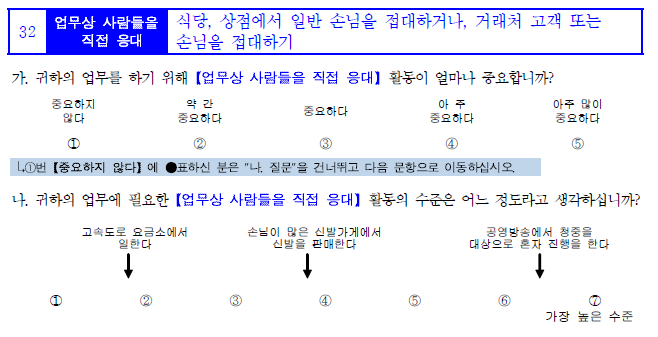

In [38]:
Image("Image/aq32_2.png")

In [39]:
train_2017[(train_2017['aq32_2'].isnull())]['aq32_1']

1458    3
2680    3
3523    3
3656    3
5301    3
6368    3
6711    3
6864    3
7435    3
9316    3
9319    3
Name: aq32_1, dtype: int64

### 33? 
#### 이 값은 3으로 대체한다.

In [40]:
test_2017[(test_2017['aq32_2'].isnull())]['aq32_1']

1362     3
1651     3
2854     3
3194     3
3216     3
3280     3
7749    33
8775     3
8811     3
8853     3
Name: aq32_1, dtype: int64

In [41]:
test_2017.loc[(test_2017['aq32_1'] == 33), 'aq32_1'] = 3
test_2017[(test_2017['aq32_2'].isnull())]['aq32_1']

1362    3
1651    3
2854    3
3194    3
3216    3
3280    3
7749    3
8775    3
8811    3
8853    3
Name: aq32_1, dtype: int64

count    4839.000000
mean        3.781773
std         0.824585
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         7.000000
Name: aq32_2, dtype: float64


Empty DataFrame
Columns: [idx, aq1_1, aq1_2, aq2_1, aq2_2, aq3_1, aq3_2, aq4_1, aq4_2, aq5_1, aq5_2, aq6_1, aq6_2, aq7_1, aq7_2, aq8_1, aq8_2, aq9_1, aq9_2, aq10_1, aq10_2, aq11_1, aq11_2, aq12_1, aq12_2, aq13_1, aq13_2, aq14_1, aq14_2, aq15_1, aq15_2, aq16_1, aq16_2, aq17_1, aq17_2, aq18_1, aq18_2, aq19_1, aq19_2, aq20_1, aq20_2, aq21_1, aq21_2, aq22_1, aq22_2, aq23_1, aq23_2, aq24_1, aq24_2, aq25_1, aq25_2, aq26_1, aq26_2, aq27_1, aq27_2, aq28_1, aq28_2, aq29_1, aq29_2, aq30_1, aq30_2, aq31_1, aq31_2, aq32_1, aq32_2, aq33_1, aq33_2, aq34_1, aq34_2, aq35_1, aq35_2, aq36_1, aq36_2, aq37_1, aq37_2, aq38_1, aq38_2, aq39_1, aq39_2, aq40_1, aq40_2, aq41_1, aq41_2, bq1, bq2, bq3, bq4, bq4_1a, bq4_1b, bq4_1c, bq5, bq5_1, bq5_2, bq6, bq7, bq8_1, bq8_2, bq8_3, bq9, bq10, ...]
Index: []

[0 rows x 156 columns]

Empty DataFrame
Columns: [idx, aq1_1, aq1_2, aq2_1, aq2_2, aq3_1, aq3_2, aq4_1, aq4_2, aq5_1, aq5_2, aq6_1, aq6_2, aq7_1, aq7_2, aq8_1, aq8_2, aq9_1, aq9_2, aq10_1, aq10_2, aq11_1, aq11_2, aq12_1, aq12_2, aq13_1, aq13_2, aq14_1, aq14_2, aq15_1, aq15_2, aq16_1, aq16_2, aq17_1, aq17_2, aq18_1, aq18_2, aq19_1, aq19_2, aq20_1, aq20_2, aq21_1, aq21_2, aq22_1, aq22_2, aq23_1, aq23_2, aq24_1, aq24_2, aq25_1, aq25_2, aq26_1, aq26_2, aq27_1, aq27_2, aq28_1, aq28_2, aq29_1, aq29_2, aq30_1, aq30_2, aq31_1, aq31_2, aq32_1, aq32_2, aq33_1, aq33_2, aq34_1, aq34_2, aq35_1, aq35_2, aq36_1, aq36_2, aq37_1, aq37_2, aq38_1, aq38_2, aq39_1, aq39_2, aq40_1, aq40_2, aq41_1, aq41_2, bq1, bq2, bq3, bq4, bq4_1a, bq4_1b, bq4_1c, bq5, bq5_1, bq5_2, bq6, bq7, bq8_1, bq8_2, bq8_3, bq9, bq10, ...]
Index: []

[0 rows x 155 columns]

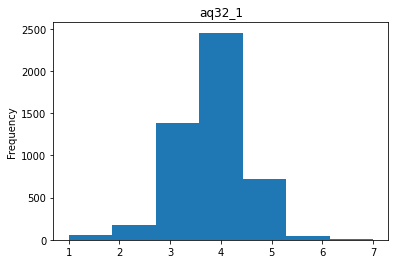

In [42]:
# 가번 문항을 3으로 선택한 사람들에 대한 결측치 값을 처리한다. 

total_2017 = pd.concat([train_2017[(train_2017['aq32_2'].notnull()) & (train_2017['aq32_1'] == 3)], test_2017[(test_2017['aq32_2'].notnull()) & (test_2017['aq32_1'] == 3)]], axis = 0)

print(total_2017['aq32_2'].astype('int').describe())

total_2017['aq32_2'].astype('int').plot.hist(bins = 7, title = "aq32_1")

train_2017.loc[(train_2017['aq32_2'].isnull()) & (train_2017['aq32_1'] == 3)] = total_2017['aq32_2'].astype('int').quantile(q = 0.5)
test_2017.loc[(test_2017['aq32_2'].isnull()) & (test_2017['aq32_1'] == 3)] = total_2017['aq32_2'].astype('int').quantile(q = 0.5)

display(train_2017.loc[(train_2017['aq32_2'].isnull()) & (train_2017['aq32_1'] == 3)])
display(test_2017.loc[(test_2017['aq32_2'].isnull()) & (test_2017['aq32_1'] == 3)])

### 1.10  aq41_2에 해당하는 결측치 처리 방법
* 결측치 처리 방식은 위와 동일하다.

In [43]:
Image("Image/aq41_2.png")

In [44]:
train_2017[(train_2017['aq41_2'].isnull())]['aq41_1']

1798    3
6894    3
7118    3
8289    3
Name: aq41_1, dtype: int64

In [45]:
test_2017[(test_2017['aq41_2'].isnull())]['aq41_1']

1284    3
3460    3
5419    3
6893    3
8305    3
Name: aq41_1, dtype: int64

count    4276.000000
mean        3.729186
std         0.840551
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         7.000000
Name: aq41_2, dtype: float64


Empty DataFrame
Columns: [idx, aq1_1, aq1_2, aq2_1, aq2_2, aq3_1, aq3_2, aq4_1, aq4_2, aq5_1, aq5_2, aq6_1, aq6_2, aq7_1, aq7_2, aq8_1, aq8_2, aq9_1, aq9_2, aq10_1, aq10_2, aq11_1, aq11_2, aq12_1, aq12_2, aq13_1, aq13_2, aq14_1, aq14_2, aq15_1, aq15_2, aq16_1, aq16_2, aq17_1, aq17_2, aq18_1, aq18_2, aq19_1, aq19_2, aq20_1, aq20_2, aq21_1, aq21_2, aq22_1, aq22_2, aq23_1, aq23_2, aq24_1, aq24_2, aq25_1, aq25_2, aq26_1, aq26_2, aq27_1, aq27_2, aq28_1, aq28_2, aq29_1, aq29_2, aq30_1, aq30_2, aq31_1, aq31_2, aq32_1, aq32_2, aq33_1, aq33_2, aq34_1, aq34_2, aq35_1, aq35_2, aq36_1, aq36_2, aq37_1, aq37_2, aq38_1, aq38_2, aq39_1, aq39_2, aq40_1, aq40_2, aq41_1, aq41_2, bq1, bq2, bq3, bq4, bq4_1a, bq4_1b, bq4_1c, bq5, bq5_1, bq5_2, bq6, bq7, bq8_1, bq8_2, bq8_3, bq9, bq10, ...]
Index: []

[0 rows x 156 columns]

Empty DataFrame
Columns: [idx, aq1_1, aq1_2, aq2_1, aq2_2, aq3_1, aq3_2, aq4_1, aq4_2, aq5_1, aq5_2, aq6_1, aq6_2, aq7_1, aq7_2, aq8_1, aq8_2, aq9_1, aq9_2, aq10_1, aq10_2, aq11_1, aq11_2, aq12_1, aq12_2, aq13_1, aq13_2, aq14_1, aq14_2, aq15_1, aq15_2, aq16_1, aq16_2, aq17_1, aq17_2, aq18_1, aq18_2, aq19_1, aq19_2, aq20_1, aq20_2, aq21_1, aq21_2, aq22_1, aq22_2, aq23_1, aq23_2, aq24_1, aq24_2, aq25_1, aq25_2, aq26_1, aq26_2, aq27_1, aq27_2, aq28_1, aq28_2, aq29_1, aq29_2, aq30_1, aq30_2, aq31_1, aq31_2, aq32_1, aq32_2, aq33_1, aq33_2, aq34_1, aq34_2, aq35_1, aq35_2, aq36_1, aq36_2, aq37_1, aq37_2, aq38_1, aq38_2, aq39_1, aq39_2, aq40_1, aq40_2, aq41_1, aq41_2, bq1, bq2, bq3, bq4, bq4_1a, bq4_1b, bq4_1c, bq5, bq5_1, bq5_2, bq6, bq7, bq8_1, bq8_2, bq8_3, bq9, bq10, ...]
Index: []

[0 rows x 155 columns]

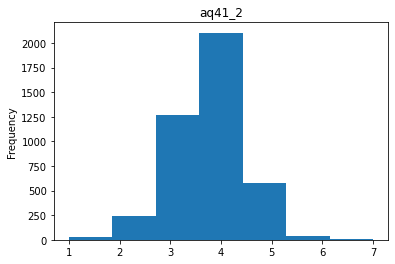

In [46]:
# 가번 문항을 3으로 선택한 사람들에 대한 결측치 값을 처리한다. 

total_2017 = pd.concat([train_2017[(train_2017['aq41_2'].notnull()) & (train_2017['aq41_1'] == 3)], test_2017[(test_2017['aq41_2'].notnull()) & (test_2017['aq41_1'] == 3)]], axis = 0)

print(total_2017['aq41_2'].astype('int').describe())

total_2017['aq41_2'].astype('int').plot.hist(bins = 7, title = "aq41_2")

train_2017.loc[(train_2017['aq41_2'].isnull()) & (train_2017['aq41_1'] == 3)] = total_2017['aq41_2'].astype('int').quantile(q = 0.5)
test_2017.loc[(test_2017['aq41_2'].isnull()) & (test_2017['aq41_1'] == 3)] = total_2017['aq41_2'].astype('int').quantile(q = 0.5)

display(train_2017.loc[(train_2017['aq41_2'].isnull()) & (train_2017['aq41_1'] == 3)])
display(test_2017.loc[(test_2017['aq41_2'].isnull()) & (test_2017['aq41_1'] == 3)])

#### aq 칼럼에 대한 결측치 제걱다 제대로 되었는지를 확인한다.

In [47]:
for index, value, tindex, tvalue in zip(train_2017.isnull().sum().index, train_2017.isnull().sum(), test_2017.isnull().sum().index, test_2017.isnull().sum()):
    print(f"{index} : {value} / {tindex} : {tvalue} / {value + tvalue}")

idx : 0 / idx : 0 / 0
aq1_1 : 0 / aq1_1 : 0 / 0
aq1_2 : 0 / aq1_2 : 0 / 0
aq2_1 : 0 / aq2_1 : 0 / 0
aq2_2 : 0 / aq2_2 : 0 / 0
aq3_1 : 0 / aq3_1 : 0 / 0
aq3_2 : 0 / aq3_2 : 0 / 0
aq4_1 : 0 / aq4_1 : 0 / 0
aq4_2 : 0 / aq4_2 : 0 / 0
aq5_1 : 0 / aq5_1 : 0 / 0
aq5_2 : 0 / aq5_2 : 0 / 0
aq6_1 : 0 / aq6_1 : 0 / 0
aq6_2 : 0 / aq6_2 : 0 / 0
aq7_1 : 0 / aq7_1 : 0 / 0
aq7_2 : 0 / aq7_2 : 0 / 0
aq8_1 : 0 / aq8_1 : 0 / 0
aq8_2 : 0 / aq8_2 : 0 / 0
aq9_1 : 0 / aq9_1 : 0 / 0
aq9_2 : 0 / aq9_2 : 0 / 0
aq10_1 : 0 / aq10_1 : 0 / 0
aq10_2 : 0 / aq10_2 : 0 / 0
aq11_1 : 0 / aq11_1 : 0 / 0
aq11_2 : 0 / aq11_2 : 0 / 0
aq12_1 : 0 / aq12_1 : 0 / 0
aq12_2 : 0 / aq12_2 : 0 / 0
aq13_1 : 0 / aq13_1 : 0 / 0
aq13_2 : 0 / aq13_2 : 0 / 0
aq14_1 : 0 / aq14_1 : 0 / 0
aq14_2 : 0 / aq14_2 : 0 / 0
aq15_1 : 0 / aq15_1 : 0 / 0
aq15_2 : 0 / aq15_2 : 0 / 0
aq16_1 : 0 / aq16_1 : 0 / 0
aq16_2 : 0 / aq16_2 : 0 / 0
aq17_1 : 0 / aq17_1 : 0 / 0
aq17_2 : 0 / aq17_2 : 0 / 0
aq18_1 : 0 / aq18_1 : 0 / 0
aq18_2 : 0 / aq18_2 : 0 / 0
aq19_1

### 1.11  bq4_1a~bq4_1c에 해당하는 결측치 처리 방법
* aq항목에 대한 결측치 제거가 완료 되었다.
* 이제는 나머지 bq 항목에 대한 결측치 제거를 실시 해보도록 하자.

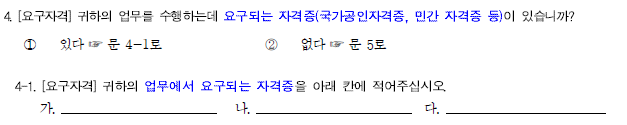

In [48]:
Image("Image/bq4_1.png")

* 4번 문항에서 2번을 선택한 사람이라면 4-1번에 질문에 답변을 할 필요가 없다.
* 이를 통해서 결측치를 확인해 보자.
* train에서 결측치 값 : 5368 / test에서 결측치 값 : 5415
* 아래의 코드를 통해서 결측치에 해당하는 값들이 모두 4번 문항에서 2번을 선택한 값이라는 것을 알 수 있다.

#### 따라서 해당하는 직업에는 별도로 요구되는 자격증이 없다는 것을 의미하기 때문에 결측치 값에 '없음'이라고 대체 해준다.

In [49]:
train_2017

idx  aq1_1 aq1_2  aq2_1 aq2_2  aq3_1 aq3_2  aq4_1 aq4_2  aq5_1  ...  \
0        0      3     3      3     3      3     3      4     4      3  ...   
1        1      4     5      4     5      3     4      3     4      3  ...   
2        2      3     4      3     4      3     4      5     6      4  ...   
3        3      3     3      3     3      3     5      4     5      4  ...   
4        4      4     5      3     4      3     4      4     5      3  ...   
...    ...    ...   ...    ...   ...    ...   ...    ...   ...    ...  ...   
9481  9481      3     5      2     4      3     3      2     2      2  ...   
9482  9482      5     5      5     5      5     5      3     4      4  ...   
9483  9483      3     3      4     6      3     3      4     5      4  ...   
9484  9484      3     5      3     5      4     5      3     4      3  ...   
9485  9485      3     4      3     4      3     4      3     4      3  ...   

     bq37  bq38  bq38_1  bq39_1 bq39_2  bq40 bq41_1  bq41_2 bq41_3  knowcode  
0      52     2      실업       1      1     1   4000     NaN   2200    825101  
1      38     4    건축공학       1      1     1    NaN     NaN   2400    140204  
2      50     4    건축공학       1      1     1   4000     NaN   2400    140204  
3      42     4    환경학과       1      1     1   7000     NaN   3500    140601  
4      51     4    건축공학       1      1     1   4000     NaN   2500    140204  
...   ...   ...     ...     ...    ...   ...    ...     ...    ...       ...  
9481   50     4   산업디자인       1      1     1   5200     NaN   1800    411301  
9482   37     4  우주항공공학       1      1     1   4000     NaN   3000    151105  
9483   32     2      기계       1      4     2   2700     NaN   1500    701101  
9484   40     4   문헌정보학       1      1     1   6800     NaN   2500     25402  
9485   48     3      전기       1      1     1   4000     NaN   3700     15201  

[9486 rows x 156 columns]

In [50]:
print(train_2017.loc[(train_2017['bq4'] == 2) & (train_2017['bq4_1a'].isnull())].shape)
print(test_2017.loc[(test_2017['bq4'] == 2) & (test_2017['bq4_1a'].isnull())].shape)

(5368, 156)
(5415, 155)


In [51]:
train_2017.loc[(train_2017['bq4'] == 2) & (train_2017['bq4_1a'].isnull()), 'bq4_1a'] = '없음'
test_2017.loc[(test_2017['bq4'] == 2) & (test_2017['bq4_1a'].isnull()), 'bq4_1a'] = '없음'

In [52]:
# 정상적으로 결측치 값이 제거되었다.
display(train_2017[(train_2017['bq4_1a'].isnull())])
display(test_2017[(test_2017['bq4_1a'].isnull())])

Empty DataFrame
Columns: [idx, aq1_1, aq1_2, aq2_1, aq2_2, aq3_1, aq3_2, aq4_1, aq4_2, aq5_1, aq5_2, aq6_1, aq6_2, aq7_1, aq7_2, aq8_1, aq8_2, aq9_1, aq9_2, aq10_1, aq10_2, aq11_1, aq11_2, aq12_1, aq12_2, aq13_1, aq13_2, aq14_1, aq14_2, aq15_1, aq15_2, aq16_1, aq16_2, aq17_1, aq17_2, aq18_1, aq18_2, aq19_1, aq19_2, aq20_1, aq20_2, aq21_1, aq21_2, aq22_1, aq22_2, aq23_1, aq23_2, aq24_1, aq24_2, aq25_1, aq25_2, aq26_1, aq26_2, aq27_1, aq27_2, aq28_1, aq28_2, aq29_1, aq29_2, aq30_1, aq30_2, aq31_1, aq31_2, aq32_1, aq32_2, aq33_1, aq33_2, aq34_1, aq34_2, aq35_1, aq35_2, aq36_1, aq36_2, aq37_1, aq37_2, aq38_1, aq38_2, aq39_1, aq39_2, aq40_1, aq40_2, aq41_1, aq41_2, bq1, bq2, bq3, bq4, bq4_1a, bq4_1b, bq4_1c, bq5, bq5_1, bq5_2, bq6, bq7, bq8_1, bq8_2, bq8_3, bq9, bq10, ...]
Index: []

[0 rows x 156 columns]

Empty DataFrame
Columns: [idx, aq1_1, aq1_2, aq2_1, aq2_2, aq3_1, aq3_2, aq4_1, aq4_2, aq5_1, aq5_2, aq6_1, aq6_2, aq7_1, aq7_2, aq8_1, aq8_2, aq9_1, aq9_2, aq10_1, aq10_2, aq11_1, aq11_2, aq12_1, aq12_2, aq13_1, aq13_2, aq14_1, aq14_2, aq15_1, aq15_2, aq16_1, aq16_2, aq17_1, aq17_2, aq18_1, aq18_2, aq19_1, aq19_2, aq20_1, aq20_2, aq21_1, aq21_2, aq22_1, aq22_2, aq23_1, aq23_2, aq24_1, aq24_2, aq25_1, aq25_2, aq26_1, aq26_2, aq27_1, aq27_2, aq28_1, aq28_2, aq29_1, aq29_2, aq30_1, aq30_2, aq31_1, aq31_2, aq32_1, aq32_2, aq33_1, aq33_2, aq34_1, aq34_2, aq35_1, aq35_2, aq36_1, aq36_2, aq37_1, aq37_2, aq38_1, aq38_2, aq39_1, aq39_2, aq40_1, aq40_2, aq41_1, aq41_2, bq1, bq2, bq3, bq4, bq4_1a, bq4_1b, bq4_1c, bq5, bq5_1, bq5_2, bq6, bq7, bq8_1, bq8_2, bq8_3, bq9, bq10, ...]
Index: []

[0 rows x 155 columns]

* 4번 문항에서 2번을 선택한 사람이라면 나머지 요구되는 자격증 모두 '없음' 이다.

In [53]:
train_2017.loc[(train_2017['bq4'] == 2) & (train_2017['bq4_1b'].isnull()), 'bq4_1b'] = '없음'
train_2017.loc[(train_2017['bq4'] == 2) & (train_2017['bq4_1c'].isnull()), 'bq4_1c'] = '없음'

test_2017.loc[(test_2017['bq4'] == 2) & (test_2017['bq4_1b'].isnull()), 'bq4_1b'] = '없음'
test_2017.loc[(test_2017['bq4'] == 2) & (test_2017['bq4_1c'].isnull()), 'bq4_1c'] = '없음'

#### bq4_1a에 동일한 자격증을 갖고 있지만 bq4_1b에는 비어 있는 경우도 있다. 

#### "귀하의 업무를 수행하는데 요구되는 자격증" 이기 때문에 같은 자격증을 갖고 있다는 것은 비슷한 업무를 할 확률이 높다. 따라서 bq4_1b에는 동일한 자격증을 기입해 준다.

In [54]:
for index in train_2017.loc[(train_2017['bq4_1b'].isnull())]['bq4_1a'].index:
    value = train_2017.iloc[index]['bq4_1a']
#     col_index = np.where(train_2017.columns == 'bq4_1a')[0][0]

    if len(train_2017[(train_2017['bq4_1a'] == value) & (train_2017['bq4_1b'].notnull()) & (train_2017['bq4_1b'] != '없음') & (train_2017['bq4_1b'] != '없다')]) > 0:
         train_2017.loc[index, 'bq4_1b'] = train_2017[(train_2017['bq4_1a'] == value) & (train_2017['bq4_1b'].notnull()) & (train_2017['bq4_1b'] != '없음') & (train_2017['bq4_1b'] != '없다')]['bq4_1b'].value_counts().index[0]

In [55]:
for index in test_2017.loc[(test_2017['bq4_1b'].isnull())].index:
    value = test_2017.iloc[index]['bq4_1a']
#     col_index = np.where(test_2017.columns == 'bq4_1a')[0][0]
    
    if len(test_2017[(test_2017['bq4_1a'] == value) & (test_2017['bq4_1b'].notnull()) & (test_2017['bq4_1b'] != '없음') & (test_2017['bq4_1b'] != '없다')]) > 0:
        test_2017.loc[index, 'bq4_1b'] = test_2017[(test_2017['bq4_1a'] == value) & (test_2017['bq4_1b'].notnull()) & (test_2017['bq4_1b'] != '없음') & (test_2017['bq4_1b'] != '없다')]['bq4_1b'].value_counts().index[0]

In [56]:
# 위에 해당하는 사항이 없다면 '없음' 값으로 초기화 한다.
train_2017.loc[(train_2017['bq4_1b'].isnull()), 'bq4_1b'] = '없음'
test_2017.loc[(test_2017['bq4_1b'].isnull()), 'bq4_1b'] = '없음'

#### 위와 같은 방식으로 2개의 자격증이 같으면 동일한 3번 째 자격증을 입력 해줘서 결측치 값을 제거해 주는 방식도 있다. 하지만 여기서는 '없음'으로 통일 하도록 하겠다.

In [57]:
train_2017.loc[(train_2017['bq4_1c'].isnull()), 'bq4_1c'] = '없음'
test_2017.loc[(test_2017['bq4_1c'].isnull()), 'bq4_1c'] = '없음'

In [58]:
for index, value, tindex, tvalue in zip(train_2017.isnull().sum().index, train_2017.isnull().sum(), test_2017.isnull().sum().index, test_2017.isnull().sum()):
    print(f"{index} : {value} / {tindex} : {tvalue} / {value + tvalue}")

idx : 0 / idx : 0 / 0
aq1_1 : 0 / aq1_1 : 0 / 0
aq1_2 : 0 / aq1_2 : 0 / 0
aq2_1 : 0 / aq2_1 : 0 / 0
aq2_2 : 0 / aq2_2 : 0 / 0
aq3_1 : 0 / aq3_1 : 0 / 0
aq3_2 : 0 / aq3_2 : 0 / 0
aq4_1 : 0 / aq4_1 : 0 / 0
aq4_2 : 0 / aq4_2 : 0 / 0
aq5_1 : 0 / aq5_1 : 0 / 0
aq5_2 : 0 / aq5_2 : 0 / 0
aq6_1 : 0 / aq6_1 : 0 / 0
aq6_2 : 0 / aq6_2 : 0 / 0
aq7_1 : 0 / aq7_1 : 0 / 0
aq7_2 : 0 / aq7_2 : 0 / 0
aq8_1 : 0 / aq8_1 : 0 / 0
aq8_2 : 0 / aq8_2 : 0 / 0
aq9_1 : 0 / aq9_1 : 0 / 0
aq9_2 : 0 / aq9_2 : 0 / 0
aq10_1 : 0 / aq10_1 : 0 / 0
aq10_2 : 0 / aq10_2 : 0 / 0
aq11_1 : 0 / aq11_1 : 0 / 0
aq11_2 : 0 / aq11_2 : 0 / 0
aq12_1 : 0 / aq12_1 : 0 / 0
aq12_2 : 0 / aq12_2 : 0 / 0
aq13_1 : 0 / aq13_1 : 0 / 0
aq13_2 : 0 / aq13_2 : 0 / 0
aq14_1 : 0 / aq14_1 : 0 / 0
aq14_2 : 0 / aq14_2 : 0 / 0
aq15_1 : 0 / aq15_1 : 0 / 0
aq15_2 : 0 / aq15_2 : 0 / 0
aq16_1 : 0 / aq16_1 : 0 / 0
aq16_2 : 0 / aq16_2 : 0 / 0
aq17_1 : 0 / aq17_1 : 0 / 0
aq17_2 : 0 / aq17_2 : 0 / 0
aq18_1 : 0 / aq18_1 : 0 / 0
aq18_2 : 0 / aq18_2 : 0 / 0
aq19_1

#### 모든 칼럼에서 '없다'라는 값을 '없음'으로 통일해 준다.

In [59]:
# '없다'라는 값을 '없음'으로 통일해 준다.
for col in test_2017:
    train_2017[col].replace('없다','없음', inplace = True)
    test_2017[col].replace('없다','없음', inplace = True)    

### 1.12  bq5_1~bq5_2 해당하는 결측치 처리 방법

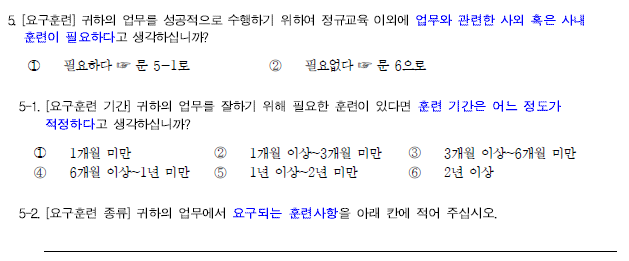

In [60]:
Image("Image/bq5.png")

#### bq5 : 0 / bq5 : 0 / 0
#### bq5_1 : 4954 / bq5_1 : 4745 / 9699
#### bq5_2 : 4955 / bq5_2 : 4746 / 9701
#### 5번 문항에서 2번을 선택했다면 5-1과 5-2를 적지 않아도 된다.
#### 하지만 1번을 선택했다면 5-1과 5-2를 적어야 한다.
#### 우선적으로 2번을 선택했을 떄, 5-1은 0으로 5-2는 '없음'으로 처리해 준다.

In [61]:
print("학습 데이터 결측치 : ", train_2017[(train_2017['bq5'] == 2) & (train_2017['bq5_1'].isnull())].shape)
print("테스트 데이터 결측치 : ", test_2017[(test_2017['bq5'] == 2) & (test_2017['bq5_1'].isnull())].shape)

학습 데이터 결측치 :  (4954, 156)
테스트 데이터 결측치 :  (4745, 155)


In [62]:
print("학습 데이터 결측치 : ", train_2017[(train_2017['bq5'] == 2) & (train_2017['bq5_2'].isnull())].shape)
print("테스트 데이터 결측치 : ", test_2017[(test_2017['bq5'] == 2) & (test_2017['bq5_2'].isnull())].shape)

학습 데이터 결측치 :  (4954, 156)
테스트 데이터 결측치 :  (4745, 155)


In [63]:
# 5번 문항에서 2번을 선택한 사람들에 대해서 5-1에 대한 값을 0으로 처리함
train_2017.loc[(train_2017['bq5'] == 2) & (train_2017['bq5_1'].isnull()),'bq5_1'] = 0
test_2017.loc[(test_2017['bq5'] == 2) & (test_2017['bq5_1'].isnull()),'bq5_1'] = 0

In [64]:
# 5번 문항에서 2번을 선택한 사람들에 대해서 5-2에 대한 값을 '없음'으로 처리함
train_2017.loc[(train_2017['bq5'] == 2) & (train_2017['bq5_2'].isnull()),'bq5_2'] = '없음'
test_2017.loc[(test_2017['bq5'] == 2) & (test_2017['bq5_2'].isnull()),'bq5_2'] = '없음'

In [65]:
# 학습 데이터와 테스트 데이터에서 한 개씩 결측치 값이 남는다.
display(train_2017[train_2017['bq5_2'].isnull()])
display(test_2017[test_2017['bq5_2'].isnull()])

idx  aq1_1 aq1_2  aq2_1 aq2_2  aq3_1 aq3_2  aq4_1 aq4_2  aq5_1  ...  \
5277  5277      3     4      2     3      3     4      1     0      3  ...   

     bq37  bq38 bq38_1  bq39_1 bq39_2  bq40 bq41_1  bq41_2 bq41_3  knowcode  
5277   54     3     기계       1      1     1   3000     NaN   2000     28204  

[1 rows x 156 columns]

idx  aq1_1 aq1_2  aq2_1 aq2_2  aq3_1 aq3_2  aq4_1 aq4_2  aq5_1  ...  \
7264  7264      4     5      4     5      4     5      1     0      3  ...   

     bq36  bq37 bq38  bq38_1 bq39_1  bq39_2 bq40  bq41_1 bq41_2  bq41_3  
7264    2    45    3    호텔경영      1       1    1    2800    NaN    2000  

[1 rows x 155 columns]

In [66]:
# train과 test 모두 필요한 자격증 값이 '없음'이기 때문에 단순히 유추하기 어렵다.
# 따라서, '없음'으로 전처리 해준다.
train_2017.loc[train_2017['bq5_2'].isnull(), 'bq5_2'] = '없음'
test_2017.loc[test_2017['bq5_2'].isnull(), 'bq5_2'] = '없음'

### 1.13  bq12 해당하는 결측치 처리 방법

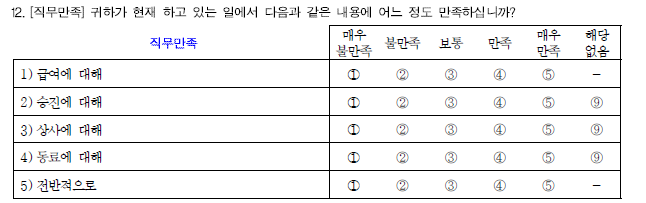

In [67]:
Image('Image/bq12.png')

#### bq12_1 : 0 / bq12_1 : 0 / 0
#### bq12_2 : 1618 / bq12_2 : 1589 / 3207
#### bq12_3 : 1336 / bq12_3 : 1316 / 2652
#### bq12_4 : 872 / bq12_4 : 871 / 1743
#### bq12_5 : 0 / bq12_5 : 0 / 0
<br>
위의 질문 사항에 결측치 값들이 이 값들은 단순하게 중앙 값으로 대체하면 안된다. 이러한 결측치 값들은 다른 특징 값과 연결 시켜서 결측치 값을 추측해야 한다.

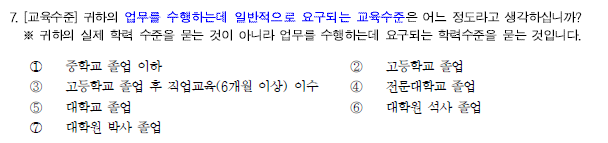

In [68]:
Image('Image/bq7.png')

* 위의 결측치 값은 7번 문항을 이용해서 추측해보록 하겠다.
* 아무래도 12번 문항에 대한 질문은 학력과 깊은 관계가 있을 것으로 추측했다.
* 따라서, 학력에 해당하는 중앙 값을 통해서 결측치를 제거한다.

In [69]:
# bq12_2 컬럼에 대한 결측치를 제거한다.

for index in train_2017.loc[(train_2017['bq12_2'].isnull())].index:
    # 학력 값을 저장함
    LevelOfEducation = train_2017.iloc[index]['bq7']

    # 학력 값에 대한 중앙값을 통해서 결측치를 제거한다.
    train_2017.loc[index, 'bq12_2'] = train_2017[(train_2017['bq7'] == LevelOfEducation) & (train_2017['bq12_2'].notnull())]['bq12_2'].astype('int').quantile(q=0.5).astype('int').astype('str')

In [70]:
train_2017[(train_2017['bq7'] == LevelOfEducation) & (train_2017['bq12_2'].notnull())]['bq12_2'].astype('int').quantile(q=0.5).astype('int')

3

In [71]:
# bq12_2 컬럼에 대한 결측치를 제거한다.

for index in test_2017.loc[(test_2017['bq12_2'].isnull())].index:
    # 학력 값을 저장함
    LevelOfEducation = test_2017.iloc[index]['bq7']

    # 학력 값에 대한 중앙값을 통해서 결측치를 제거한다.
    test_2017.loc[index, 'bq12_2'] = test_2017[(test_2017['bq7'] == LevelOfEducation) & (test_2017['bq12_2'].notnull())]['bq12_2'].astype('int').quantile(q=0.5).astype('int').astype('str')

In [72]:
train_2017['bq12_2']

0       3
1       3
2       4
3       3
4       3
       ..
9481    4
9482    3
9483    3
9484    3
9485    5
Name: bq12_2, Length: 9486, dtype: object

bq12_3과 bq12_4 컬럼 또한 위와 같은 방식을 통해서 결측치를 제거한다.

In [73]:
train_2017['bq12_4']

0       4
1       4
2       4
3       3
4       4
       ..
9481    4
9482    3
9483    4
9484    4
9485    5
Name: bq12_4, Length: 9486, dtype: object

In [74]:
# bq12_3 컬럼에 대한 결측치를 제거한다.

for index in train_2017.loc[(train_2017['bq12_3'].isnull())].index:
    # 학력 값을 저장함
    LevelOfEducation = train_2017.iloc[index]['bq7']

    # 학력 값에 대한 중앙값을 통해서 결측치를 제거한다.
    train_2017.loc[index, 'bq12_3'] = train_2017[(train_2017['bq7'] == LevelOfEducation) & (train_2017['bq12_3'].notnull())]['bq12_3'].astype('int').quantile(q=0.5).astype('int').astype('str')
    
for index in test_2017.loc[(test_2017['bq12_3'].isnull())].index:
    # 학력 값을 저장함
    LevelOfEducation = test_2017.iloc[index]['bq7']

    # 학력 값에 대한 중앙값을 통해서 결측치를 제거한다.
    test_2017.loc[index, 'bq12_3'] = test_2017[(test_2017['bq7'] == LevelOfEducation) & (test_2017['bq12_3'].notnull())]['bq12_3'].astype('int').quantile(q=0.5).astype('int').astype('str')    

In [75]:
# bq12_4 컬럼에 대한 결측치를 제거한다.

for index in train_2017.loc[(train_2017['bq12_4'].isnull())].index:
    # 학력 값을 저장함
    LevelOfEducation = train_2017.iloc[index]['bq7']

    # 학력 값에 대한 중앙값을 통해서 결측치를 제거한다.
    train_2017.loc[index, 'bq12_4'] = train_2017[(train_2017['bq7'] == LevelOfEducation) & (train_2017['bq12_4'].notnull())]['bq12_4'].astype('int').quantile(q=0.5).astype('int').astype('str')

for index in test_2017.loc[(test_2017['bq12_4'].isnull())].index:
    # 학력 값을 저장함
    LevelOfEducation = test_2017.iloc[index]['bq7']

    # 학력 값에 대한 중앙값을 통해서 결측치를 제거한다.
    test_2017.loc[index, 'bq12_4'] = test_2017[(train_2017['bq7'] == LevelOfEducation) & (test_2017['bq12_4'].notnull())]['bq12_4'].astype('int').quantile(q=0.5).astype('int').astype('str')

### 1.13  bq19_1 해당하는 결측치 처리 방법

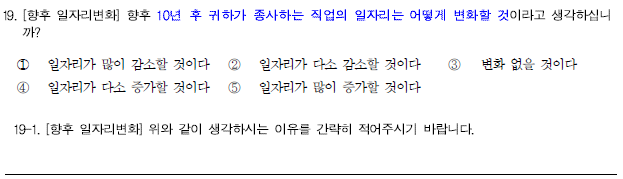

In [76]:
Image('Image/bq19.png')

19-1 같은 경우는 '없음' 이라고 결측치 처리를 하겠다.

In [77]:
train_2017.loc[train_2017['bq19_1'].isnull()] = '없음'
test_2017.loc[test_2017['bq19_1'].isnull()] = '없음'

### 1.14  bq30 해당하는 결측치 처리 방법

In [78]:
# 직전에 직업이 었는 사람인 것을 확인 했다.
# 따라서 별도의 직업을 달리 부르는 명칭이 존재하지 않는다.
print(test_2017[test_2017['bq30'].isnull()]['bq32'])
test_2017.loc[test_2017['bq30'].isnull()] = '없음'

1897    없음
Name: bq32, dtype: object


### 1.15  bq31 해당하는 결측치 처리 방법

사용하는 프로그램이기 때문에 직업과 깊은 관계가 있어 보인다.

In [79]:
Image('Image/bq31.png')

* 이 값을 추측 하기 위해서는 다른 변수들과 연관 시켜서 추측 해야 한다. 
* 추측을 위해서 다음 문항들을 참고하겠다.
<hr>
1. >> "1. [산업 유형] 귀하는 어떤 곳(산업)에 근무하고 계십니까?"
2. >> "30. [유사직업명] 현장에서 귀하의 직업을 달리 부르는 명칭이 있다면 있는 대로 적어주시기 바랍니다."
3. >> "32. [직전직업] 귀하의 직전 직업을 적어주시기 바랍니다."
4. >> "33. [전직 가능직업] 귀하가 현재 직업의 경력을 잘 활용하여 전직 가능한 직업이 있다면 적어주기 바랍니다."

In [80]:
for index, value, tindex, tvalue in zip(train_2017.isnull().sum().index, train_2017.isnull().sum(), test_2017.isnull().sum().index, test_2017.isnull().sum()):
    print(f"{index} : {value} / {tindex} : {tvalue} / {value + tvalue}")

idx : 0 / idx : 0 / 0
aq1_1 : 0 / aq1_1 : 0 / 0
aq1_2 : 0 / aq1_2 : 0 / 0
aq2_1 : 0 / aq2_1 : 0 / 0
aq2_2 : 0 / aq2_2 : 0 / 0
aq3_1 : 0 / aq3_1 : 0 / 0
aq3_2 : 0 / aq3_2 : 0 / 0
aq4_1 : 0 / aq4_1 : 0 / 0
aq4_2 : 0 / aq4_2 : 0 / 0
aq5_1 : 0 / aq5_1 : 0 / 0
aq5_2 : 0 / aq5_2 : 0 / 0
aq6_1 : 0 / aq6_1 : 0 / 0
aq6_2 : 0 / aq6_2 : 0 / 0
aq7_1 : 0 / aq7_1 : 0 / 0
aq7_2 : 0 / aq7_2 : 0 / 0
aq8_1 : 0 / aq8_1 : 0 / 0
aq8_2 : 0 / aq8_2 : 0 / 0
aq9_1 : 0 / aq9_1 : 0 / 0
aq9_2 : 0 / aq9_2 : 0 / 0
aq10_1 : 0 / aq10_1 : 0 / 0
aq10_2 : 0 / aq10_2 : 0 / 0
aq11_1 : 0 / aq11_1 : 0 / 0
aq11_2 : 0 / aq11_2 : 0 / 0
aq12_1 : 0 / aq12_1 : 0 / 0
aq12_2 : 0 / aq12_2 : 0 / 0
aq13_1 : 0 / aq13_1 : 0 / 0
aq13_2 : 0 / aq13_2 : 0 / 0
aq14_1 : 0 / aq14_1 : 0 / 0
aq14_2 : 0 / aq14_2 : 0 / 0
aq15_1 : 0 / aq15_1 : 0 / 0
aq15_2 : 0 / aq15_2 : 0 / 0
aq16_1 : 0 / aq16_1 : 0 / 0
aq16_2 : 0 / aq16_2 : 0 / 0
aq17_1 : 0 / aq17_1 : 0 / 0
aq17_2 : 0 / aq17_2 : 0 / 0
aq18_1 : 0 / aq18_1 : 0 / 0
aq18_2 : 0 / aq18_2 : 0 / 0
aq19_1

In [81]:
for index in train_2017[(train_2017['bq31'].isnull())].index:
    # 산업 유형
    industry_type = train_2017.iloc[index]['bq1']
    # 유사직업명
    a_similar_job = train_2017.iloc[index]['bq30']
    # 직전직업
    before_job = train_2017.iloc[index]['bq32']
    # 전직 가능직업
    can_change_job = train_2017.iloc[index]['bq33']
    

    if len(train_2017[(train_2017['bq31'].notnull())&(train_2017['bq1'] == industry_type) & (train_2017['bq30'] == a_similar_job) & (train_2017['bq32'] == before_job) & (train_2017['bq33'] == can_change_job)]):
        # 산업 유형 + 유사 직업명 + 직전 직업 + 전직 가능 직업
        train_2017.loc[index, 'bq31'] = train_2017[(train_2017['bq31'].notnull())&(train_2017['bq1'] == industry_type) & (train_2017['bq30'] == a_similar_job) & (train_2017['bq32'] == before_job) & (train_2017['bq33'] == can_change_job)]['bq31'].value_counts().index[0]
    elif len(train_2017[(train_2017['bq31'].notnull())&(train_2017['bq1'] == industry_type) & (train_2017['bq30'] == a_similar_job) & (train_2017['bq32'] == before_job)]):
        # 산업 유형 + 유사 직업명 + 직전 직업
        train_2017.loc[index, 'bq31'] = train_2017[(train_2017['bq31'].notnull())&(train_2017['bq1'] == industry_type) & (train_2017['bq30'] == a_similar_job) & (train_2017['bq32'] == before_job)]['bq31'].value_counts().index[0]
    elif len(train_2017[(train_2017['bq31'].notnull())& (train_2017['bq30'] == a_similar_job) & (train_2017['bq32'] == before_job) & (train_2017['bq33'] == can_change_job)]):
        #  유사 직업명 + 직전 직업 + 전직 가능 직업
        train_2017.loc[index, 'bq31'] = train_2017[(train_2017['bq31'].notnull())& (train_2017['bq30'] == a_similar_job) & (train_2017['bq32'] == before_job) & (train_2017['bq33'] == can_change_job)]['bq31'].value_counts().index[0]
    elif len(train_2017[(train_2017['bq31'].notnull())&(train_2017['bq1'] == industry_type) & (train_2017['bq30'] == a_similar_job)]):
        # 산업 유형 + 유사 직업명
        train_2017.loc[index, 'bq31'] = train_2017[(train_2017['bq31'].notnull())&(train_2017['bq1'] == industry_type) & (train_2017['bq30'] == a_similar_job)]['bq31'].value_counts().index[0]
    elif len(train_2017[(train_2017['bq31'].notnull())&(train_2017['bq1'] == industry_type) & (train_2017['bq30'] == a_similar_job) & (train_2017['bq32'] == before_job)]):
        # 산업 유형 + 직전 직업
        train_2017.loc[index, 'bq31'] = train_2017[(train_2017['bq31'].notnull())&(train_2017['bq1'] == industry_type) & (train_2017['bq30'] == a_similar_job) & (train_2017['bq32'] == before_job)].value_counts().index[0]
    elif len(train_2017[(train_2017['bq31'].notnull())& (train_2017['bq32'] == before_job) & (train_2017['bq33'] == can_change_job)]):
        # 직전 직업 + 전직 가능직업
        train_2017.loc[index, 'bq31'] = train_2017[(train_2017['bq31'].notnull())& (train_2017['bq32'] == before_job) & (train_2017['bq33'] == can_change_job)].value_counts().index[0]
    elif len(train_2017[(train_2017['bq31'].notnull())& (train_2017['bq32'] == before_job)]):
        # 직전 직업
        train_2017.loc[index, 'bq31'] = train_2017[(train_2017['bq31'].notnull())& (train_2017['bq32'] == before_job)].value_counts().index[0]
    elif len(train_2017[(train_2017['bq31'].notnull()) & (train_2017['bq33'] == can_change_job)]):
        # 전직 가능직업
        train_2017.loc[index, 'bq31'] = train_2017[(train_2017['bq31'].notnull()) & (train_2017['bq33'] == can_change_job)].value_counts().index[0]
    elif len(train_2017[(train_2017['bq31'].notnull())& (train_2017['bq30'] == a_similar_job)]):
        # 유사 직업명
        train_2017.loc[index, 'bq31'] = train_2017[(train_2017['bq31'].notnull())& (train_2017['bq30'] == a_similar_job)].value_counts().index[0]
    else:
        # 이정도면 없음으로 할게요...
        train_2017.loc[index, 'bq31'] = '없음'

In [82]:
for index in test_2017[(test_2017['bq31'].isnull())].index:
    # 산업 유형
    industry_type = test_2017.iloc[index]['bq1']
    # 유사직업명
    a_similar_job = test_2017.iloc[index]['bq30']
    # 직전직업
    before_job = test_2017.iloc[index]['bq32']
    # 전직 가능직업
    can_change_job = test_2017.iloc[index]['bq33']

    if len(test_2017[(test_2017['bq31'].notnull()) & (test_2017['bq1'] == industry_type) & (
            test_2017['bq30'] == a_similar_job) & (test_2017['bq32'] == before_job) & (
                              test_2017['bq33'] == can_change_job)]):
        # 산업 유형 + 유사 직업명 + 직전 직업 + 전직 가능 직업
        test_2017.loc[index, 'bq31'] = test_2017[
            (test_2017['bq31'].notnull()) & (test_2017['bq1'] == industry_type) & (
                        test_2017['bq30'] == a_similar_job) & (test_2017['bq32'] == before_job) & (
                        test_2017['bq33'] == can_change_job)]['bq31'].value_counts().index[0]
    elif len(test_2017[(test_2017['bq31'].notnull()) & (test_2017['bq1'] == industry_type) & (
            test_2017['bq30'] == a_similar_job) & (test_2017['bq32'] == before_job)]):
        # 산업 유형 + 유사 직업명 + 직전 직업
        test_2017.loc[index, 'bq31'] = test_2017[
            (test_2017['bq31'].notnull()) & (test_2017['bq1'] == industry_type) & (
                        test_2017['bq30'] == a_similar_job) & (test_2017['bq32'] == before_job)][
            'bq31'].value_counts().index[0]
    elif len(test_2017[(test_2017['bq31'].notnull()) & (test_2017['bq30'] == a_similar_job) & (
            test_2017['bq32'] == before_job) & (test_2017['bq33'] == can_change_job)]):
        #  유사 직업명 + 직전 직업 + 전직 가능 직업
        test_2017.loc[index, 'bq31'] = test_2017[
            (test_2017['bq31'].notnull()) & (test_2017['bq30'] == a_similar_job) & (
                        test_2017['bq32'] == before_job) & (test_2017['bq33'] == can_change_job)][
            'bq31'].value_counts().index[0]
    elif len(test_2017[(test_2017['bq31'].notnull()) & (test_2017['bq1'] == industry_type) & (
            test_2017['bq30'] == a_similar_job)]):
        # 산업 유형 + 유사 직업명
        test_2017.loc[index, 'bq31'] = test_2017[
            (test_2017['bq31'].notnull()) & (test_2017['bq1'] == industry_type) & (
                        test_2017['bq30'] == a_similar_job)]['bq31'].value_counts().index[0]
    elif len(test_2017[(test_2017['bq31'].notnull()) & (test_2017['bq1'] == industry_type) & (
            test_2017['bq30'] == a_similar_job) & (test_2017['bq32'] == before_job)]):
        # 산업 유형 + 직전 직업
        test_2017.loc[index, 'bq31'] = test_2017[
            (test_2017['bq31'].notnull()) & (test_2017['bq1'] == industry_type) & (
                        test_2017['bq30'] == a_similar_job) & (test_2017['bq32'] == before_job)].value_counts().index[
            0]
    elif len(test_2017[(test_2017['bq31'].notnull()) & (test_2017['bq32'] == before_job) & (
            test_2017['bq33'] == can_change_job)]):
        # 직전 직업 + 전직 가능직업
        test_2017.loc[index, 'bq31'] = test_2017[
            (test_2017['bq31'].notnull()) & (test_2017['bq32'] == before_job) & (
                        test_2017['bq33'] == can_change_job)].value_counts().index[0]
    elif len(test_2017[(test_2017['bq31'].notnull()) & (test_2017['bq32'] == before_job)]):
        # 직전 직업
        test_2017.loc[index, 'bq31'] = \
        test_2017[(test_2017['bq31'].notnull()) & (test_2017['bq32'] == before_job)].value_counts().index[0]
    elif len(test_2017[(test_2017['bq31'].notnull()) & (test_2017['bq33'] == can_change_job)]):
        # 전직 가능직업
        test_2017.loc[index, 'bq31'] = \
        test_2017[(test_2017['bq31'].notnull()) & (test_2017['bq33'] == can_change_job)].value_counts().index[0]
    elif len(test_2017[(test_2017['bq31'].notnull()) & (test_2017['bq30'] == a_similar_job)]):
        # 유사 직업명
        test_2017.loc[index, 'bq31'] = \
        test_2017[(test_2017['bq31'].notnull()) & (test_2017['bq30'] == a_similar_job)].value_counts().index[0]
    else:
        # 이정도면 없음으로 할게요...
        test_2017.loc[index, 'bq31'] = '없음'


### 1.16  bq32 해당하는 결측치 처리 방법

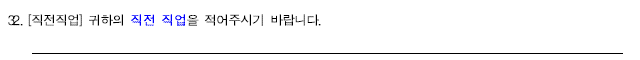

In [83]:
Image('Image/bq32.png')

####  직전 직업에 대한 결측치 값은 모두 '모름'으로 통일 하겠다.

In [84]:
train_2017.loc[train_2017['bq32'].isnull(), 'bq32'] = '모름' 
test_2017.loc[test_2017['bq32'].isnull(), 'bq32'] = '모름' 

### 1.17  bq33 해당하는 결측치 처리 방법

##### 사실은 bq31과 같은 사용 가능한 프로그램 같은 경우는 프로그램의 종류 별로 컬럼을 새로 만드는 것이 좋다고 생각합니다. 이를 통해서 bq33 결측치 값을 좀 더 세밀하게 처리할 수 있습니다 Ex) 엑셀, 워드를 다룰 수 있다면 엑셀과 워드에 해당하는 컬럼을 따로 만드는 것이 좋다(원-핫 인코딩 과 같은)
##### 하지만 BaseLine을 지향하는 코드이기 때문에 이러한 세밀한 조정은 넣지 않았습니다.
##### 이러한 세밀한 조정은 위의 코드들로 부터도 충분히 가능하기 때문에 별도로 넣지 않겠습니다.



<hr><hr>
일부 컬럼에서 의미가 같은 단어를 다른 방식으로 표현하는 부분들이 많다.
Ex) 컴퓨터와 PC를 혼용해서 사용하는 컬럼들이 보인다. <br><br>
이는 모델링 작업시 모두 동일한 형태로 변환 해주는 것이 좋다고 생각합니다. 모델링 작업이 끝나면 이러한 모든 부분을 수정해서 공유하도록 하겠습니다.

### 1.17  bq34 해당하는 결측치 처리 방법

In [85]:
Image('Image/bq34.png')

해당하는 자만 응답하라고 있기 때문에 '모름' or '없음'으로 처리해 준다.

In [86]:
train_2017.loc[(train_2017['bq34'].isnull()), 'bq34'] = '모름'
test_2017.loc[(test_2017['bq34'].isnull()), 'bq34'] = '모름'

### 1.18  bq38_1 해당하는 결측치 처리 방법

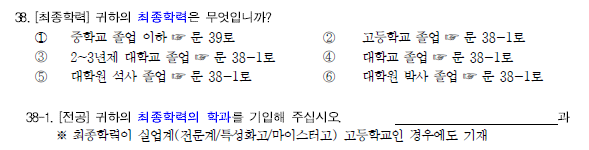

In [87]:
Image('Image/bq38_1.png')

##### 아래는 중학교만 졸업한 사람의 수를 보여준다.
##### 결측치 값인 "bq38_1 : 268 / bq38_1 : 276 / 544 " 와 동일한 수치를 보여주고 있다.
##### 즉, 중학교만 졸업 했기 때문에 38-1를 기입할 수 없는 것이다. 이러한 값들은 모두 '없음'으로 바꿔준다.

In [88]:
print(f"train : {train_2017[train_2017['bq38_1'].isnull()]['bq38'].shape[0]}")
print(f"test : {test_2017[test_2017['bq38_1'].isnull()]['bq38'].shape[0]}")

train : 268
test : 276


In [89]:
train_2017.loc[train_2017['bq38_1'].isnull()] = '없음'
test_2017.loc[test_2017['bq38_1'].isnull()] = '없음'

### 1.19  bq40 해당하는 결측치 처리 방법

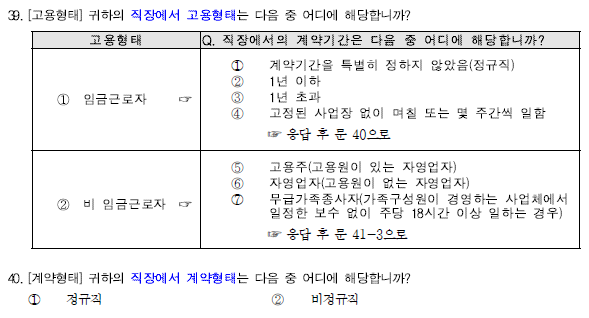

In [90]:
Image('Image/bq40.png')

##### 40번 문항의 결측치 값을 보기 이전에 결측치 값에 해당하는 사람들이 39번 문항에 어떠한 답변을 했는지 확인해야 한다.
##### 40번 문항의 결측치 값 "bq40 : 1297 / bq40 : 1319 / 2616"
##### 39번 문항을 제대로 기입 했다면 모두 '비 임금근로자'에 해당하기 때문에 40번 문항에 해당하지 않게 된다. 따라서, 이러한 값 모두는 3번이라는 새로운 카테고리를 할당해 준다.

In [91]:
print(train_2017[(train_2017['bq40'].isnull())]['bq39_2'].value_counts())
print(test_2017[(test_2017['bq40'].isnull())]['bq39_2'].value_counts())

6    581
5    578
7     22
Name: bq39_2, dtype: int64
5    582
6    571
7     34
Name: bq39_2, dtype: int64


In [92]:
train_2017.loc[(train_2017['bq39_1'] == 2) & (train_2017['bq40'].isnull())] = '3'
test_2017.loc[(test_2017['bq39_1'] == 2) & (test_2017['bq40'].isnull())] = '3'

### 1.20  bq41_1 ~ bq41_3 해당하는 결측치 처리 방법

위에 해당하는 컬럼들은 사용하지 않도록 하겠습니다.

# 최종 결측치 수 파악

In [93]:
train_2017 = train_2017.drop(columns = ['bq41_1', 'bq41_2', 'bq41_3'])
test_2017 = test_2017.drop(columns = ['bq41_1', 'bq41_2', 'bq41_3'])

In [94]:
for index, value, tindex, tvalue in zip(train_2017.isnull().sum().index, train_2017.isnull().sum(), test_2017.isnull().sum().index, test_2017.isnull().sum()):
    print(f"{index} : {value} / {tindex} : {tvalue} / {value + tvalue}")

idx : 0 / idx : 0 / 0
aq1_1 : 0 / aq1_1 : 0 / 0
aq1_2 : 0 / aq1_2 : 0 / 0
aq2_1 : 0 / aq2_1 : 0 / 0
aq2_2 : 0 / aq2_2 : 0 / 0
aq3_1 : 0 / aq3_1 : 0 / 0
aq3_2 : 0 / aq3_2 : 0 / 0
aq4_1 : 0 / aq4_1 : 0 / 0
aq4_2 : 0 / aq4_2 : 0 / 0
aq5_1 : 0 / aq5_1 : 0 / 0
aq5_2 : 0 / aq5_2 : 0 / 0
aq6_1 : 0 / aq6_1 : 0 / 0
aq6_2 : 0 / aq6_2 : 0 / 0
aq7_1 : 0 / aq7_1 : 0 / 0
aq7_2 : 0 / aq7_2 : 0 / 0
aq8_1 : 0 / aq8_1 : 0 / 0
aq8_2 : 0 / aq8_2 : 0 / 0
aq9_1 : 0 / aq9_1 : 0 / 0
aq9_2 : 0 / aq9_2 : 0 / 0
aq10_1 : 0 / aq10_1 : 0 / 0
aq10_2 : 0 / aq10_2 : 0 / 0
aq11_1 : 0 / aq11_1 : 0 / 0
aq11_2 : 0 / aq11_2 : 0 / 0
aq12_1 : 0 / aq12_1 : 0 / 0
aq12_2 : 0 / aq12_2 : 0 / 0
aq13_1 : 0 / aq13_1 : 0 / 0
aq13_2 : 0 / aq13_2 : 0 / 0
aq14_1 : 0 / aq14_1 : 0 / 0
aq14_2 : 0 / aq14_2 : 0 / 0
aq15_1 : 0 / aq15_1 : 0 / 0
aq15_2 : 0 / aq15_2 : 0 / 0
aq16_1 : 0 / aq16_1 : 0 / 0
aq16_2 : 0 / aq16_2 : 0 / 0
aq17_1 : 0 / aq17_1 : 0 / 0
aq17_2 : 0 / aq17_2 : 0 / 0
aq18_1 : 0 / aq18_1 : 0 / 0
aq18_2 : 0 / aq18_2 : 0 / 0
aq19_1

# 